# Physics Informed Neural Networks (PINN): Tutorial
> For the Fall 2024 course: *Machine Learning in Physics*<br>
> Created: Aug. 14, 2024 Harrison B. Prosper

## Introduction
Most differential equations cannot be solved exactly. Therefore, over the centuries many numerical methods have been devised to solve them approximately. A relatively recent numerical approach formulates the solution of a differential equation as an optimization problem in which the approximate solution is modeled using one or more neural networks. For an excellent introduction, I recommend the lectures by Bob Moseley (see, for example, https://www.youtube.com/watch?v=IDIv92Z6Qvc). For a thorough review, see for example, https://doi.org/10.48550/arXiv.2201.05624.

In this tutorial we consider the example presented by Bob Moseley in the lecture cited above, namely the solution $u(t) \in \mathbb{R}$, $t \in \mathbb{R}^+$, of the ordinary differential equation (ODE)
\begin{align}
   \frac{d^2u}{dt^2} + 2 \lambda \frac{du}{dt} + \omega_0^2 u = 0,  
\end{align}
describing a 1D **damped harmomic oscillator**, where 
\begin{align}
    \lambda & = \frac{\mu}{m} \quad\text{and}\\
    \omega_0 & = \sqrt{\frac{k}{m}}
\end{align}
are the characteristic decay rate of the oscillation amplitude and the characteristic frequency, respectively. (In Bob's lecture $\lambda = \delta$.) The quantity $m$ is the mass, $k$ the spring constant and $\mu$ the coefficient of kinetic friction. To obtain a particular solution of the equation we must specify initial conditions
\begin{align}
    u(t=0) & = u_0, \\
    \left. \frac{du}{dt}\right|_{t=0} & = v_0 . 
\end{align}

We can incorporate the initial conditions explicitly through an *ansatz* for $u(t)$ such as
\begin{align}
    u(t) & = u_0 + v_0 \, t + f(t) \, t^2, 
\end{align}
where $f(t)$ is a function to be determined. In practice, we'll use a better ansatz. The basic idea is to solve the ODE by minimizing the objective function
\begin{align}
    R(\theta) & = \frac{1}{N} \sum_{i=1}^N \left( \, \frac{d^2 u_i}{dt^2} + 2 \lambda \frac{d u_i}{dt} + \omega_0^2 u_i \, \right)^2,\quad\text{where}\\
    u_i & \equiv u(t_i; \theta),
\end{align}
and $f(t; \theta)$  is a parameterized function with free parameters $\theta$
and the timestamps $t_i$, called **collocation points**, are sampled over the desired domain of the solution.

When the parametrized function $f(t; \theta)$ is a neural network the latter is called by the misnomer **physics-informed neural network** (PINN). It is clearly a misnomer because this very powerful and general idea for solving a differential equation can be applied to *any* differential equation not just the ones in physics! The approach is feasible because the derivatives that enter the objective function can be computed *exactly* using **automatic differentiation**.

## Conditioned PINNs
Automatic differentiation is the key technology that has enabled the use of increasingly complex models in contemporary machine learning. However, when the computation graph is extended to incorporate derivatives with respect to the inputs, this can lead to an explosion in the size of the computation graph, which makes solving differential equations through this method considerably slower than algorithms that use finite differences. But if we condition the solution on the initial conditions $u_0$ and $v_0$ the high cost of finding the solutions using stochastic gradient descent for the subset of initial conditions  is *amortized* over the subsequent rapid application of the PINN for any initial condition within that subset. In a finite-difference calculation, a different calculation would be needed for each set of initial (or boundary) conditions. A PINN conditioned on the initial conditions is called a **conditioned PINN** (CPINN).  In principle, this approach can be extended to any set of parameters of the differential equation, as we do in this tutorial. 

One of the nice features of CPINNs is that the solution can be checked at a few selected parameter points by comparing the CPINN solution with solutions obtained using standard finite-difference methods.

## A Few Details
It is almost always a good idea to try to simplify a differential equation before solving it. We can simplify the ODE by dividing throughout by $\omega_0^2$, defining the dimensionless quantities $z = \omega_0 \, t$, $\alpha = \lambda /\omega_0 $. With these changes, the ODE becomes
\begin{align}
  \frac{d^2u}{dt^2}  +  2 \alpha \frac{d u}{dt} + u = 0 . 
\end{align}
Since this is a linear equation, we can try a solution of the form
\begin{align}
    u(z) & = A \exp(i q z + \phi),
\end{align}
where $A$ and $\phi$ are constants to be determined by the initial conditions and where it is understood that we'll take the real part of $u(z)$ at the end. One finds $q = i \alpha \pm \sqrt{1 - \alpha^2}$. Taking the positive value of $\sqrt{1 - \alpha^2}$ and restricting to the condition $\alpha < 1$ the exact solution is given by
\begin{align}
    u(t) & = A \exp(-\alpha z) \, \cos\left(z \sqrt{1-\alpha^2} + \phi\right)  \quad\text{and} \\
    \phi & = \arctan\left(-\frac{(\alpha + v_0 / u_0)}{\sqrt{1 - \alpha^2}}\right), \quad A = \frac{u_0}{\cos\phi} .
\end{align}
(Note: In terms of the original parameters, 
 the exact solution of the ODE for $\alpha < 1$, that is, $\omega_0 > \lambda$, is 
\begin{align}
    u(t) & = A \exp(-\lambda t) \, \cos(\omega \, t + \phi), \quad\text{with } \omega = \sqrt{\omega_0^2 - \lambda^2} \quad\text{and} \\
    \phi & = \arctan(-(\lambda + v_0 / u_0) \, / \, \omega), \quad A = u_0 \, / \, \cos\phi ).
\end{align}

In this tutorial we'll condition the CPINN not only on the initial conditions $u_0$ and $v_0$ but also on the parameter $\alpha$. In effect, we'll generate an infinite number of solutions indexed by the triplet $(u_0, v_0, \alpha)$.
Since the ODE is linear in $u(t)$, we can take $u_0 \in [-1, 1]$ without loss of generality. We'll take the initial velocity of the object in the range $v_0 \in [-2, 2]$, $\alpha \in [0, 0.5]$, and to accomodate a range of $\omega_0$ and $t$ values we'll take $z \in [0, z_\max]$, but scale down the $z$ value entered into the neural network by $z_\max$, which we set to 20.

In [16]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

# needed to generate Sobol sequences of points (quasi-random sampling)
from scipy.stats import qmc

# a simple time left function written by HBP
from lossmonitor import Monitor, TimeLeft

# update fonts
FONTSIZE = 12
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device: {str(device):4s}')

Available device: cpu 


## Exact solution
\begin{align}
    u(z) & = A \exp(-\alpha z) \, \cos\left(z \sqrt{1-\alpha^2} + \phi\right)  \quad\text{and} \\
    \phi & = \arctan\left(-\frac{(\alpha + v_0 / u_0)}{\sqrt{1 - \alpha^2}}\right), \quad A = \frac{u_0}{\cos\phi} .
\end{align}

In [3]:
def exact_solution(z, u0, v0, alpha):
    assert alpha > 0
    assert alpha < 1
    a = np.sqrt(1 - alpha**2)
    phi = np.arctan(-(alpha + v0/u0)/a)
    A = u0 / np.cos(phi)
    u = A * torch.exp(-alpha*z) * torch.cos(a*z + phi)
    return u

## Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of the fitted model.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

## Generate data
Here we generate a quasi-random set of points $x = (z, u_0, v_0, \alpha) \in S \subset \mathbb{R}^4$.

In [4]:
def sobol_sequence(D, P, lower, upper):
    # D: dimension of input space
    # P: number of points = 2^P
    
    # generate 2^P points in D-dimensional unit hypercube
    sampler= qmc.Sobol(d=D, scramble=True)
    sample = sampler.random_base2(m=P)

    # scale to desired size of hyperrectangle
    sample = qmc.scale(sample, lower, upper)

    # convert to torch tensor of float32
    sample = torch.Tensor(sample)
    return sample

# -----------------------------------------------------------
# CONSTANTS
# -----------------------------------------------------------
LOSS_FILE = 'losses.csv'
DICT_FILE = 'model.dict'
PLOT_FILE = 'results.png'
TIMELEFT_FILE = 'timeleft.txt'

# define domain of CPINN
#           z,  u0,  v0, alpha
LOWER = [ 0.0,-1.0,-2.0, 0.0]
UPPER = [20.0, 1.0, 2.0, 0.5]
SCALE = [20.0, 1.0, 2.0, 1.0]    # See Solution class below

# -----------------------------------------------------------
# DATA
# -----------------------------------------------------------
# we'll be computing du/dx so we need to alert PyTorch of this.
X = sobol_sequence(len(LOWER), 16, LOWER, UPPER).requires_grad_(True).to(device)

X.shape

torch.Size([65536, 4])

In [5]:
n_train = 60000
n_valid =  5000

i = 0; j= i + n_train
train_X = X[i:j]

i += n_train; j = i + n_valid
valid_X = X[i:j]

train_X.shape, valid_X.shape

(torch.Size([60000, 4]), torch.Size([5000, 4]))

## Define a fully-connected neural network

### $\texttt{SiLU}(x)$

$\text{silu}(x) = x \, \sigma(x), \text{where } \sigma(x) \text{ is the logistic sigmoid.}$

In [6]:
class FCN(nn.Module):
    def __init__(self, n_input, n_hidden, n_width, 
                 nonlinearity=nn.SiLU):
        
        super().__init__()
        
        self.input = nn.Sequential(nn.Linear(n_input, n_width), nonlinearity())

        cmd  = 'nn.Sequential('
        cmd += ', '.join(['nn.Linear(n_width, n_width), nonlinearity()' 
                          for _ in range(n_hidden)])
        cmd += ')'
        self.hidden = eval(cmd)
        
        self.output = nn.Linear(n_width, 1)

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)       
        return x

## Model solution ansatz
We'll use the following solution ansatz
\begin{align}
    u(z)  & = \frac{u_0 + z \, v_0 + z^2 \, f(x; \theta)}{1+z^2}, \\
    \frac{du(z)}{dz} & = \frac{-2 z \, u_0 + (1-z^2) \, v_0 + 2z \, f(x;\theta)}{(1+z^2)^2} +  \frac{z^2}{1+z^2} \, \frac{df(x;\theta)}{dz},
\end{align}
where $x = (z, u_0, v_0, \alpha)$.
Note this ansatz satisfies $u \rightarrow f$ and $du/dz \rightarrow df/dz$ as $z \rightarrow \infty$.

In [7]:
# The "Solution" class inherits the properties of nn.Module
class Solution(nn.Module):
    
    def __init__(self, NN, scale, dictfile=DICT_FILE):

        # remember to initialize base (that is, parent) class
        super().__init__()

        # cache neural network and send to computational device
        self.f = NN.to(device)  
        
        # scale is needed to ensure that the inputs to the neural network 
        # are all of order 1. 
        # unsqueeze(dim=0) does the following: (4) => (1, 4)
        self.scale = torch.tensor(scale).unsqueeze(dim=0).to(device) # shape: (1, 4)
        
        self.dictfile = dictfile

    def save(self):
        # save parameters of neural network
        torch.save(self.f.state_dict(), self.dictfile)

    def load(self):
        # load parameters of neural network
        self.f.eval()
        self.f.load_state_dict(torch.load(self.dictfile))

    def forward(self, x):
        # get z = omega_0 * t, u0 = u(0) and v0 = du(0)/dz
        z, u0, v0 = [x[:, i].view(-1, 1) for i in range(3)]

        # compute ansatz
        zz = z**2
        x  = x / self.scale
        u  = (u0 + z * v0 + zz * self.f(x)) / (1+zz)

        return u

## Model objective function
\begin{align}
    \frac{d^2u}{dz^2} + 2 \alpha \frac{du}{dz} + u & = 0.
\end{align}

In [8]:
class Objective(nn.Module):

    def __init__(self, solution):
        super().__init__()        
        self.solution = solution

    def eval(self):
        self.solution.eval()

    def train(self):
        self.solution.train()

    def save(self):
        self.solution.save()
        
    def forward(self, x):
        
        if len(x.shape) < 2:
            x = x.unsqueeze(dim=0) # this does the following: (-1) => (1, -1)

        u = self.solution(x)
        
        # compute du/dx = [d/dz, d/du0, d/dv0, d/dalpha]u.
        #
        # Note: autograd.grad computes the gradient of scalars. but since
        # u is generally a batch of scalars with shape (batch-size, 1), we need to
        # tell autograd.grad to apply the gradient operator to every scalar in the
        # batch of scalars. this we do by passing autograd.grad a tensor of shape
        # (batch-size, 1) filled with ones. it is also necessary to create the
        # the computation graph for this operation. finally, we take the zeroth
        # element because autograd.grad returns a tuple.
        
        dudx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]

        # pick off du/dz and make sure its shape is correct
        
        dudz = dudx[:, 0].view(-1, 1)

        # now compute d/dx (du/dz), that is, (d/dz, d/du0, d/du1, d/dalpha) du/dz.
        # in other words: d2u/dz2, d2u/du0dz, d2u/du1dz, d2u/dalphadz
        
        d2u = torch.autograd.grad(dudz, x, 
                                  torch.ones_like(u), 
                                  create_graph=True)[0]

        # pick off d2u/dz2 and make sure it's a batch of scalars. 
        
        d2udz2 = d2u[:, 0].view(-1, 1)

        # pick off alpha and also make sure it's a batch of scalars.
        
        alpha = x[:, -1].view(-1, 1)

        # compute objective function

        O = d2udz2 + 2*alpha*dudz + u
        
        R = torch.mean(O**2)
        
        return R

In [9]:
def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_random_batch(x, batch_size):
    indices = torch.randint(0, len(x)-1, size=(batch_size,))
    return x[indices]

## Define solver

In [10]:
def solve(objective, optimizer, getbatch, train_x, valid_x, batch_size,
          number_iterations,
          lossfile=LOSS_FILE,
          timeleftfile=TIMELEFT_FILE,
          step=100):

    def validate(fcn, x):
        fcn.eval()
        return fcn(x)
       
    n = len(valid_x)

    # start saving best model after the following number of iterations.
    
    start_saving = number_iterations // 100
    best_model   = None
    min_avloss   = float('inf')  # initialize minimum average loss

    # initialize loss file
    # create loss file if it 
    if not os.path.exists(lossfile):
        open(lossfile, 'w').write('iteration,t_loss,v_loss\n')  

    # get last iteration number from file
    df = pd.read_csv(lossfile)
    if len(df) < 1:
        itno = 0
    else:
        itno = df.iteration.iloc[-1] # get last iteration number

    # enter training loop
    
    timeleft = TimeLeft(number_iterations)
    
    for ii in range(number_iterations):
        
        optimizer.zero_grad()       # clear previous gradients
        
        # set mode to training so that training-specific 
        # operations such as dropout, etc., are enabled.
        
        objective.train()
    
        # get a batch of data 
        
        x = getbatch(train_x, batch_size)     

        y = objective(x)            # compute objective with current parameters

        y.backward()                # compute gradients 
        
        optimizer.step()            # move one step

        # i'm alive printout
        
        if ii % step == 0:
            
            t_loss = validate(objective, train_x[:n]).detach()
            
            v_loss = validate(objective, valid_x).detach()

            # update loss file
            
            open(loss_file, 'a').write(f'{itno:12d},{t_loss:12.6},{v_loss:12.6}\n')

            # save model paramters to file
            
            if v_loss < min_avloss:
                min_avloss = v_loss
                if ii > start_saving:
                    objective.save()

            # update time left file
            
            line = f'|{itno:12d}|{t_loss:12.6f}|{v_loss:12.6f}|'
            timeleft(ii, line)
            open(timeleftfile, 'w').write(f'{str(timeleft):s}\n')
            
            itno += step

    print()      
    return 

## Instantiate solution and objective

In [11]:
fcn  = FCN(n_input=4, n_hidden=5, n_width=25).to(device)

soln = Solution(fcn, SCALE, dictfile=DICT_FILE).to(device)

objective = Objective(soln).to(device)

number_of_parameters(fcn), objective

(3401,
 Objective(
   (solution): Solution(
     (f): FCN(
       (input): Sequential(
         (0): Linear(in_features=4, out_features=25, bias=True)
         (1): SiLU()
       )
       (hidden): Sequential(
         (0): Linear(in_features=25, out_features=25, bias=True)
         (1): SiLU()
         (2): Linear(in_features=25, out_features=25, bias=True)
         (3): SiLU()
         (4): Linear(in_features=25, out_features=25, bias=True)
         (5): SiLU()
         (6): Linear(in_features=25, out_features=25, bias=True)
         (7): SiLU()
         (8): Linear(in_features=25, out_features=25, bias=True)
         (9): SiLU()
       )
       (output): Linear(in_features=25, out_features=1, bias=True)
     )
   )
 ))

## Train!

In [12]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(objective.parameters(), lr=learning_rate) 

step = 100

In [13]:
DELETE_LOSS_FILE = True

niterations = 200001
batch_size  =    256    # sample over which to compute average loss
loss_file   = LOSS_FILE
timeleft_file = TIMELEFT_FILE

if DELETE_LOSS_FILE:
    os.system(f'rm -f {loss_file:s}')

solve(objective, optimizer, get_random_batch,
            train_X, valid_X, batch_size, niterations,
            loss_file, timeleft_file, step)

    200001|100.00%|00:15:20/00:00:00| 217.4 it/s|      200000|    0.000035|    0.000041|



## Plot solutions

In [14]:
def get_data(K=12):

    # generate random parameter points
    
    U0 = np.random.uniform(LOWER[1], UPPER[1], K)
    V0 = np.random.uniform(LOWER[2], UPPER[2], K)
    ALPHA = np.random.uniform(LOWER[3], UPPER[3], K)

    # load model with smallest objective function value 
    # over the validation set
    
    soln.load()

    # loop over parameter points
    
    data = []
    
    for i, (u0, v0, alpha) in enumerate(zip(U0, V0, ALPHA)):
        
        print(f'\r{i:5d}', end='')

        # generate equally space points in z; make sure shape is correct
        
        z = torch.linspace(LOWER[0], UPPER[0], 201).view(-1, 1)

        exact = exact_solution(z, u0, v0, alpha)

        # compute approximate solution
        
        x = torch.cat([z, 
                       u0*torch.ones_like(z),
                       v0*torch.ones_like(z), 
                       alpha*torch.ones_like(z)], dim=1).to(device)
        approx = soln(x)

        # detach from computation graphs and return as numpy arrays
        
        z = z.squeeze().detach().numpy()
        exact = exact.squeeze().detach().numpy()
        
        # the tensor could be on a GPU. need to copy tensor to CPU before
        # it can be converted to a numpy array
        
        approx = approx.squeeze().detach().cpu().numpy()
        
        # cache results
        
        data.append([z, exact, approx, u0, v0, alpha])
        
    print()
    return data

data = get_data()

   11


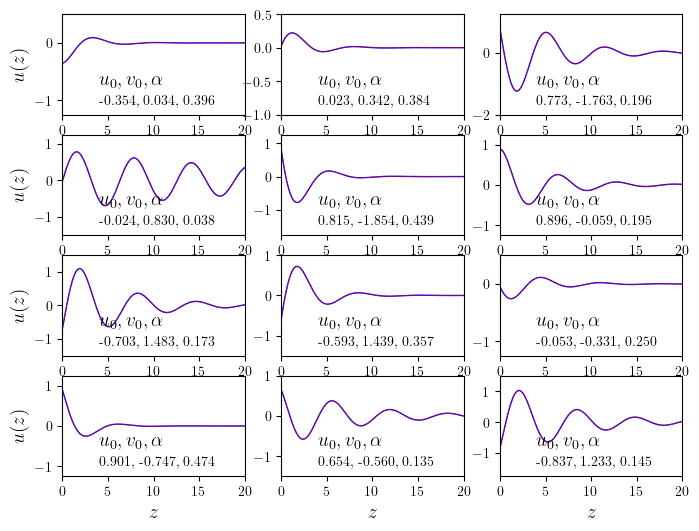

In [19]:
def plot_results(data, 
                 xmin=LOWER[0],  xmax=UPPER[0],
                 filename=PLOT_FILE,
                 fgsize=(8, 6), 
                 ftsize=14):

    plt.rcParams.update({'font.size': 10})

    # create an empty figure
    fig = plt.figure(figsize=fgsize)
    fig.tight_layout()

    # work out number of columns and number of plots
    ncols = 3
    nrows = len(data) // ncols
    ndata = nrows * ncols

    for i, (x, exact, approx, u0, v0, alpha) in enumerate(data):

        index = i+1
        ax  = fig.add_subplot(nrows, ncols, index)
        
        # setup x-axis
        ax.set_xlim(xmin, xmax)
        
        if i > (nrows-1) * ncols-1:
            ax.set_xlabel(r'$z$', fontsize=ftsize)
        
        if i % ncols == 0:
            ax.set_ylabel(r'$u(z)$', fontsize=ftsize)

        # annotate plot
        dy = 0.25
        ymin = exact.min()
        n = int(np.abs(ymin)/dy)+4
        ymin = np.sign(ymin)*n*dy

        ymax = exact.max()
        n = int(np.abs(ymax)/dy)+2
        ymax = np.sign(ymax)*n*dy
        ax.set_ylim(ymin, ymax)

        xpos = xmin + 0.20 * (xmax-xmin)
        ypos = ymin + 0.30 * (ymax-ymin)
        ystep= (ymax-ymin)/5
        
        ax.text(xpos, ypos, r'$u_0, v_0, \alpha$', fontsize=14); ypos -= ystep
        ax.text(xpos, ypos, '%8.3f,%8.3f,%8.3f' % (u0, v0, alpha)); ypos -= ystep

        ax.plot(x, exact,  color='blue', linestyle='solid', linewidth=1.0)
        ax.plot(x, approx, color='red', linestyle='dashed', linewidth=0.5)
        
    plt.savefig(filename)
    #plt.show() # omit plt.show() to avoid launching window outside notebook

plot_results(data)